In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from astropy.table import Table, Column
import astropy.units as u
from astropy.coordinates import SkyCoord, ICRS
from astropy.io import ascii

In [2]:
from firefly.data_reader.GAIAreader import GaiaReader

palettable colormaps are not installed
don't have phil's colormaps


In [3]:
import os

In [4]:

gaiadir = os.path.join(os.environ['HOME'],'projects','gaia','GaiaSource')
my_reader = GaiaReader(nthreads=52)

DR3-noRV - 3906 nodes - 3 tracked fields
No work to be done! Celebrate!
0.2594718019167582 min elapsed
Make sure each field_array (3) has a field_filter_flag (0), assuming True.
Make sure each field_array (3) has a field_colormap_flag (0), assuming True.
Make sure each field_array (3) has a field_radius_flag (0), assuming False.
DR3-RV - 1654 nodes - 3 tracked fields
No work to be done! Celebrate!
0.005832481384277344 min elapsed
Make sure each field_array (3) has a field_filter_flag (0), assuming True.
Make sure each field_array (3) has a field_colormap_flag (0), assuming True.
Make sure each field_array (3) has a field_radius_flag (0), assuming False.
datadir: /home/abg6257/projects/gaia -- is not a sub-directory of firefly/static/data. 
This may produce confusing or inoperable results. As such, we will create a symlink for you when you writeToDisk.
Importing existing settings from /projects/b1026/agurvich/Firefly/src/firefly/static/data/gaia/GaiaDataSettings.json


In [9]:
my_reader.writeToDisk()

DR3-noRV - 3906 nodes - 3 tracked fields
DR3-RV - 1654 nodes - 3 tracked fields


''

-----

In [3]:
import h5py
import numpy as np
import time
import os
import multiprocessing

In [4]:
from abg_python.plot_utils import plt

%matplotlib inline

In [4]:
from firefly.data_reader.octree_stream import OctreeStream,OctNodeStream

In [12]:
from firefly.data_reader.GAIAreader import GaiaReader

In [5]:
def readGaiaFile(path,limiting_mag,extra_keys=None,loud=False,has_RV=True):
    useGaiaData = {}
    
    if extra_keys is None: extra_keys  = []
    
    keys = ['dec','ra','parallax','pmdec','pmra','radial_velocity','bp_rp','phot_g_mean_mag'] + extra_keys
    
    with h5py.File(path,'r') as handle:
    
        for key in keys: 
            try:
                unit_strs = handle[key].attrs['unit'].decode('utf-8').split('.')
                units = 1
                for unit_str in unit_strs:
                    if '**-1' in unit_str: units/=getattr(u,unit_str[:-4])
                    else: units*=getattr(u,unit_str)
            except:
                print(unit_str)
                raise
            useGaiaData[key] = handle[key][()]*units
            nans = np.isnan(useGaiaData[key])
            #if loud: print(key,':',f"{np.sum(nans)/nans.size*100:.1f} %")
        #if loud: print(nans.size,'stars')

    mask = np.isfinite(useGaiaData['radial_velocity'])
    
    if not has_RV: mask = ~mask
    
    mask = np.logical_and(mask, useGaiaData['parallax'] > 0)
    
    outdict = {}
    
    if has_RV:
        astropy_coords = ICRS(
            ra = useGaiaData['ra'][mask], 
            dec = useGaiaData['dec'][mask], 
            distance = useGaiaData['parallax'][mask].to(u.parsec,equivalencies=u.parallax()),
            pm_ra_cosdec = useGaiaData['pmra'][mask],
            pm_dec = useGaiaData['pmdec'][mask],
            radial_velocity = useGaiaData['radial_velocity'][mask])

        ## store velocity data only if we have radial velocity
        outdict['vx'] = astropy_coords.velocity.d_x.value
        outdict['vy'] = astropy_coords.velocity.d_y.value
        outdict['vz'] = astropy_coords.velocity.d_z.value
    else:
        astropy_coords = ICRS(
            ra = useGaiaData['ra'][mask], 
            dec = useGaiaData['dec'][mask], 
            distance = useGaiaData['parallax'][mask].to(u.parsec,equivalencies=u.parallax()))
        
    outdict['x'] = astropy_coords.cartesian.x.value
    outdict['y'] = astropy_coords.cartesian.y.value
    outdict['z'] = astropy_coords.cartesian.z.value
 
    outdict['bp_rp'] = np.array(useGaiaData['bp_rp'])[mask]
    outdict['phot_g_mean_mag'] = np.array(useGaiaData['phot_g_mean_mag'])[mask]
    
    if limiting_mag is not None:
        key = 'phot_g_mean_mag'
        mask = outdict[key] <= limiting_mag
        for sub_key in keys: outdict[sub_key] = outdict[sub_key][mask]
            
    return outdict
    
def getStars(
    path,
    loud=False,
    limiting_mag=None,
    has_RV=True):
    outdfRV = readGaiaFile(path,limiting_mag,loud=loud,has_RV = has_RV)
    keys = list(outdfRV.keys())
    
    ## apply filter
    if loud: print(outdfRV[keys[0]].size,'before')
    for key in keys:

        mask = np.isfinite(outdfRV[key])
        if loud: print(key,np.sum(mask)/mask.size)
        for sub_key in keys:
            outdfRV[sub_key] = outdfRV[sub_key][mask]
    if loud: print(outdfRV[keys[0]].size,'after')
    
    return_value = np.array([outdfRV[key] for key in keys])
    return return_value

def getNoRV(path): 
    return getStars(path,has_RV=False)

def getRV(path): return getStars(path)

In [6]:
from scipy.interpolate import interp1d

def remap_nonparametrically(values,old_interval,new_interval):
    h,_ = np.histogram(values,bins=np.linspace(*old_interval))
    new_edges = np.linspace(*new_interval)
    probs = np.cumsum(h)/np.sum(h)
    probs[0] = 0
    inverter = interp1d(probs,new_edges[1:])
    new_values = inverter(np.random.uniform(0,1,values.shape[0]))
    
    sort_indices = np.argsort(values)
    new_values = np.sort(new_values)[np.argsort(sort_indices)]
    return new_values

In [7]:
keys = ['vx','vy','vz','x','y','z','bp_rp','phot_g_mean_mag']
gaiadir = os.path.join(os.environ['HOME'],'projects','gaia','GaiaSource')

In [8]:
nmax = 1000000
init_time = time.time()
append_dict = None
gaiadir = os.path.join(os.environ['HOME'],'projects','gaia','GaiaSource')
fnames = os.listdir(gaiadir)[:nmax]
fnames = [f'{gaiadir}/%s'%fname for fname in fnames]

use_mps = True
fn = getNoRV
if not use_mps: output = list(map(fn,fnames))
else: 
    with multiprocessing.Pool(min(len(fnames),multiprocessing.cpu_count())) as my_pool:
        output = my_pool.map(fn,fnames)

all_arrays = np.concatenate(output,axis=1)
print(all_arrays.shape)
print(time.time()-init_time,'s elapsed')

(5, 1000907978)
145.08232498168945 s elapsed


In [9]:
data_dict = dict(zip(keys[-all_arrays.shape[0]:],all_arrays))
old_interval = (0,4)
new_interval = (np.log10(2e3),5)
data_dict['teff_bprp'] = remap_nonparametrically(data_dict['bp_rp'],old_interval,new_interval)

In [10]:
root = OctNodeStream(None,None,[])

In [11]:
output_dir = os.path.join(os.path.dirname(gaiadir),os.path.dirname(gaiadir),'octree_full')
root_dict = root.set_buffers_from_dict(data_dict,output_dir)
stream = OctreeStream(output_dir)

{''} still need to be refined


In [8]:
output_dir = os.path.join(os.path.dirname(gaiadir),os.path.dirname(gaiadir),'octree_full')
stream = OctreeStream(output_dir)
stream.full_refine(52,4,use_mps=True)

set() still need to be refined
OctreeStream(1/3906)
set() still need to be refined
No work to be done! Celebrate!
0.008250033855438233 min elapsed


In [56]:
import astropy

In [ ]:
sets = [set([directory for directory in os.listdir(fname) if os.path.isdir(fname+'/'+directory)]) for fname in fnames]

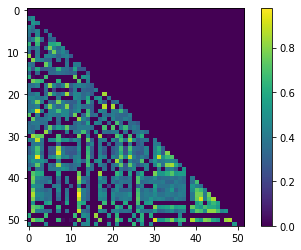

In [22]:

def find_overlaps(sets):
    
    overlaps = np.zeros((len(sets),len(sets)))
    
    for i in range(len(sets)):
        for j in range(i):
            this_set = sets[i]
            that_set = sets[j]
            overlaps[i,j] = len(this_set.intersection(that_set))/len(this_set)
    return overlaps

overlaps = find_overlaps(sets)

plt.imshow(overlaps)
plt.colorbar()

In [4]:
use_mps = True
top_level_dir = '/projects/b1026/agurvich/gaia/octree_small'
fnames = os.listdir(top_level_dir)
fnames = [os.path.join(top_level_dir,fname) for fname in fnames]

fn = refineOctreeFromRaw

if not use_mps: output = list(map(fn,fnames))
else: 
    with multiprocessing.Pool(min(len(fnames),multiprocessing.cpu_count())) as my_pool:
        output = my_pool.map(fn,fnames)

Bulding octree of 565982 pointsBulding octree of 565983 points
Bulding octree of 565982 pointsBulding octree of 565982 points
Bulding octree of 565982 pointsBulding octree of 565982 pointsBulding octree of 565982 pointsBulding octree of 565982 pointsBulding octree of 565982 pointsBulding octree of 565982 pointsBulding octree of 565982 pointsBulding octree of 565982 pointsBulding octree of 565982 pointsBulding octree of 565982 points0.00%
Bulding octree of 565982 points0.00%









	
Bulding octree of 565982 points0.00%0.00%Bulding octree of 565982 points0.00%0.00%0.00%0.00%0.00%	0.00%	0.00%0.00%0.00%
	
					0.00%		0.00%
		0.00%1.77%	1.77%0.00%	1.77%		1.77%1.77%	1.77%Bulding octree of 565982 points1.77%1.77%1.77%		1.77%1.77%		1.77%			
	Bulding octree of 565982 points		1.77%	1.77%1.77%3.53%3.53%	3.53%	1.77%	3.53%3.53%
	0.00%3.53%			1.77%			Bulding octree of 565982 points
3.53%3.53%0.00%3.53%	3.53%3.53%		Bulding octree of 565982 pointsBulding octree of 565983 points	3.53%Bulding octree 

In [23]:
foo = """XpContinuousMeanSpectrum/	2.644TB	2022-06-01 11:39 UTC
Ravedr6BestNeighbour/	32.24MB	2022-06-01 05:15 UTC
NssNonLinearSpectro/	5.263MB	2022-06-01 05:15 UTC
VariEpochRadialVelocity/	6.706MB	2022-06-01 05:18 UTC
GoldSampleSpss/	48.14KB	2022-06-01 05:15 UTC
NssAccelerationAstro/	98.39MB	2022-06-01 05:15 UTC
VariClassifierDefinition/	6.129KB	2022-06-01 05:18 UTC
XpSampling/	2.250MB	2022-06-01 11:56 UTC
AstrophysicalParameters/	1.343TB	2022-06-01 04:19 UTC
AlertsMixedinSourceids/	4.297KB	2022-06-05 16:09 UTC
VariPlanetaryTransit/	988.6KB	2022-06-01 05:19 UTC
VariAgn/	35.98MB	2022-06-01 05:18 UTC
GoldSampleObaStars/	34.60MB	2022-06-01 05:15 UTC
VariRrlyrae/	463.7MB	2022-06-01 05:19 UTC
SsoSource/	12.40MB	2022-06-01 05:17 UTC
BinaryMasses/	30.23MB	2022-06-01 03:51 UTC
VariRotationModulation/	1.416GB	2022-06-01 05:19 UTC
RvsMeanSpectrum/	18.05GB	2022-06-01 05:17 UTC
VariCompactCompanion/	22.43MB	2022-06-01 05:18 UTC
McmcSamplesMsc/	1.147TB	2022-06-06 00:33 UTC
XpSampledMeanSpectrum/	89.14GB	2022-06-01 11:56 UTC
SsoObservation/	8.216GB	2022-06-01 05:17 UTC
GoldSampleCarbonStars/	125.1KB	2022-06-01 05:15 UTC
Ravedr6Neighbourhood/	35.72MB	2022-06-01 05:15 UTC
NssVimFl/	207.8KB	2022-06-01 05:15 UTC
VariMsOscillator/	18.82MB	2022-06-01 05:19 UTC
VariShortTimescale/	40.40MB	2022-06-01 05:19 UTC
VariMicrolensing/	4.272MB	2022-06-01 05:19 UTC
TotalGalacticExtinctionMapOpt/	93.00MB	2022-06-05 17:49 UTC
SsoOrbits/	89.53MB	2022-06-01 05:17 UTC
ScienceAlerts/	88.27KB	2022-06-05 16:18 UTC
GoldSampleFgkmStars/	374.2MB	2022-06-01 05:15 UTC
NssTwoBodyOrbit/	511.5MB	2022-06-01 05:15 UTC
QsoCandidates/	2.097GB	2022-06-01 05:15 UTC
GoldSampleUcd/	662.3KB	2022-06-01 05:15 UTC
GoldSampleSolarAnalogues/	47.90KB	2022-06-01 05:15 UTC
VariSummary/	3.222GB	2022-06-01 05:20 UTC
VariCepheid/	91.86MB	2022-06-01 05:18 UTC
VariClassifierClassDefinition/	9.547KB	2022-06-01 05:18 UTC
TotalGalacticExtinctionMap/	171.3MB	2022-06-05 17:47 UTC
SsoReflectanceSpectrum/	81.93MB	2022-06-01 05:17 UTC
QsoCatalogueName/	49.61MB	2022-06-01 05:15 UTC
Ravedr6Join/	29.67MB	2022-06-01 05:15 UTC
GalaxyCandidates/	1.565GB	2022-06-01 05:14 UTC
AstrophysicalParametersSupp/	311.3GB	2022-06-01 03:51 UTC
McmcSamplesGspPhot/	2.855TB	2022-06-06 09:58 UTC
XpSummary/	13.10GB	2022-06-01 11:58 UTC
OaNeuronXpSpectra/	2.394MB	2022-06-05 16:16 UTC
XpMerge/	10.79KB	2022-06-01 11:39 UTC
VariClassifierResult/	223.5MB	2022-06-01 05:18 UTC
GalaxyCatalogueName/	18.44MB	2022-06-01 05:15 UTC
OaNeuronInformation/	333.1KB	2022-06-05 16:13 UTC
EpochPhotometry/	135.5GB	2022-06-01 03:55 UTC
GaiaCrf3Xm/	580.5MB	2022-06-01 04:19 UTC
VariEclipsingBinary/	407.4MB	2022-06-01 05:18 UTC
VariLongPeriodVariable/	79.12MB	2022-06-01 05:19 UTC
SyntheticPhotometryGspc/	36.91GB	2022-06-01 05:18 UTC
aux/	862.3KB	2022-06-05 17:51 UTC
VariRadVelStatistics/	9.526MB	2022-06-01 05:19 UTC
GaiaSource/	0.990TB	2022-06-01 05:14 UTC"""

bar = np.array([string.split('\t') for string in foo.split('\n')])

sizes = []
fact = 1024

for size in bar[:,1]:
    if 'KB' in size: power = 1
    elif 'MB' in size: power = 2
    elif 'GB' in size: power = 3
    elif 'TB' in size: power = 4
    else: raise ValueError
    sizes+=[eval(size[:-2])*fact**power]
np.sum(sizes)/fact**4

9.588463290900924

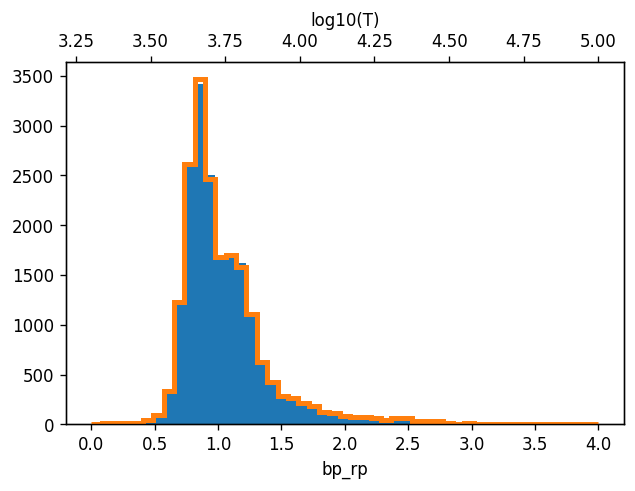

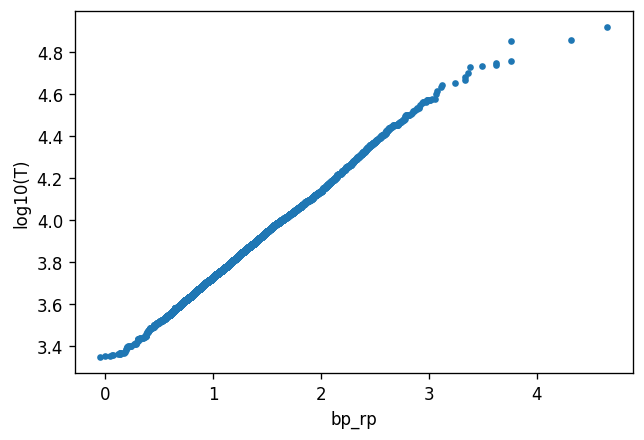

In [62]:
old_interval = (0,4)
new_interval = (np.log10(2e3),5)
temps = remap_nonparametrically(outdfRV['bp_rp'],old_interval,new_interval)

h,edges,p = plt.hist(outdfRV['bp_rp'],bins=np.linspace(*old_interval))
ax1 = plt.gca()
ax2 = ax1.twiny()

ax2.hist(temps,bins=np.linspace(*new_interval),histtype='step',color='C1',lw=3)

ax1.set_xlabel('bp_rp')
ax2.set_xlabel('log10(T)')
plt.gcf().set_facecolor('white')
plt.gcf().set_dpi(120)

plt.figure()
plt.plot(outdfRV['bp_rp'],temps,'.')
plt.gca().set_ylabel('log10(T)')
plt.gca().set_xlabel('bp_rp')
plt.gcf().set_dpi(120)
plt.gcf().set_facecolor('white')

In [63]:
outdfRV.keys()

dict_keys(['x', 'y', 'z', 'vx', 'vy', 'vz', 'bp_rp', 'phot_g_mean_mag'])

In [64]:
coordinates = np.zeros((outdfRV['x'].shape[0],3))
velocities = np.zeros((outdfRV['x'].shape[0],3))

for i,axis in enumerate(['x','y','z']):
    coordinates[:,i] = outdfRV[axis]
    velocities[:,i] = outdfRV[f'v{axis}']
coordinates

array([[ 1.68367381e+02,  6.53687185e+01, -7.54486191e+02],
       [ 1.61237326e+02,  6.25836230e+01, -7.18833031e+02],
       [ 1.88487222e+02,  7.45352916e+01, -8.42938793e+02],
       ...,
       [ 2.91750752e+01,  2.39391026e+02, -1.02051802e+03],
       [ 5.62918348e+02,  4.35007267e+03, -1.85454459e+04],
       [ 1.49357826e+01,  1.17563941e+02, -4.99866294e+02]])

In [66]:
fields = {key:outdfRV[key] for key in ['bp_rp','phot_g_mean_mag']}
fields['minus_mag'] = -fields['phot_g_mean_mag']
fields['log10Temperature'] = temps
for key,value in fields.items():
    print(key,np.min(value),np.max(value))

bp_rp -0.048840523 4.6543627
phot_g_mean_mag 4.331589 16.216284
minus_mag -16.216284 -4.331589
log10Temperature 3.3470547510700426 4.915392704155563


In [71]:
from firefly.data_reader import ArrayReader

In [73]:
reader = ArrayReader(
    ## don't have to pass as a list with 1 element 
    ##  if only 1 particle group
    coordinates,
    velocities,
    'DR3-RV',
    fields,
    JSONdir='GaiaeDR3', ## if not an absolute path assumes from ~
    clean_JSONdir=True, ## delete old files in the directory
    write_startup=True, ## overwrite the startup file (and turn off PG append)
    write_to_disk=False, ## whether to write to disk at the end of __init__
    field_filter_flags=[True,True,False,True], ## flags corresponding to fields
    field_colormap_flags=[True,True,False,True],
    field_radius_flags=[False,False,True,False],
)

reader.settings['sizeMult']['DR3-RV'] = 1
#reader.settings['radiusVariable']['eDR3-RV'] = 1

## pick the last colormap, blackbody
index = (256/8-1)
reader.settings['colormap']['DR3-RV'] = (index + 0.5) * (8/256)
reader.settings['colormapVariable']['DR3-RV'] = 2
reader.settings['showColormap']['DR3-RV'] = True
reader.settings['GUIExcludeList'] = [
    'DR3-RV/dropdown/colormap',
    'DR3-RV/colorPicker',
    'DR3-RV/dropdown/general/radiusVariableSelector']


reader.writeToDisk()

JSONdir: /home/abg6257/GaiaeDR3 -- is not a sub-directory of firefly/static/data. 
This may produce confusing or inoperable results. As such, we will create a symlink for you when you writeToDisk.
filter/colormap/radius flags correspond to: ['bp_rp', 'phot_g_mean_mag', 'minus_mag', 'log10Temperature']
Outputting: DR3-RV - 19264/19264 particles - 5 tracked fields


''